In [4]:
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import minimize, fsolve
from scipy.integrate import quad

In [120]:
#define relevant paths and names
#script_path = os.path.realpath(__file__) if a .py is run
script_path = os.getcwd()
base_path =  script_path.split('scripts')[0]
fits_path = base_path.split('Secondary_radiation')[0] + 'synchrotron_data/'
fits_name = 'm31cm3nthnew.ss.90sec.fits'
fig_path = base_path + 'figs/'
array_path = base_path + 'funcs+params_Andromeda3/'

In [38]:
beta_deg=77.5
beta = beta_deg*np.pi/180

def get_data_and_info(fits_path, fits_name):
    #extract data and information about data
    hdul = fits.open(fits_path+fits_name)
    data_uJ = hdul[0].data[0]
    data = data_uJ/1000 #mJ/beam
    hdr = hdul[0].header
    dlt_N_deg = abs(hdr['CDELT1'])
    dlt_n_deg = abs(hdr['CDELT2'])
    N = hdr['NAXIS1']
    n = hdr['NAXIS2']
    nu_data = hdr['CRVAL3']
    nu_BW = hdr['CDELT3']
    HPBW_deg = hdr['BMIN']
    return data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW 
def make_coords(N, n, dlt_N, dlt_n, loc='centered'):
    if loc=='centered':
        ax_N_unit = np.linspace(-(N-1)/2, (N-1)/2, N)
        ax_n_unit = np.linspace(-(n-1)/2, (n-1)/2, n)
    elif loc=='edges':
        ax_N_unit = np.linspace(-N/2, N/2, N+1)
        ax_n_unit = np.linspace(-n/2, n/2, n+1)
    return dlt_N*ax_N_unit, dlt_n*ax_n_unit
def Q_pm(R, z, args):
    a0, N, q, k, h = args
    a = np.sqrt(R**2+z**2/q**2)
    return (h/(4*np.pi*q*a0**3))*np.exp(-(a/(k*a0))**(1/N))
def Q(R, z, w, args_plus):
    a0, N, q, k, h = args_plus
    args_min = (w*a0, N, q/w, k, h)
    return Q_pm(R, z, args_plus) - (w**2)*Q_pm(R, z, args_min)
def emis(l, rho, phi, w, args_plus):
    R = np.sqrt((rho**2)*(np.cos(phi)**2)+(rho*np.sin(phi)*np.cos(beta)+ l*np.sin(beta))**2)
    z = -rho*np.sin(phi)*np.sin(beta)+l*np.cos(beta)
    return Q(R, z, w, args_plus)

In [41]:
#extract info about data
data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW = get_data_and_info(fits_path, fits_name)
dlt_N = dlt_N_deg*np.pi/180
dlt_n = dlt_n_deg*np.pi/180
HPBW = HPBW_deg*np.pi/180
sigma_BW = HPBW/(2*np.sqrt(2*np.log(2)))
omega_beam = 2*np.pi*sigma_BW**2
print('real data info extracted')

#create coords for data
ax_N, ax_n = make_coords(N, n, dlt_N, dlt_n)
AX_N, AX_n = np.meshgrid(ax_N, ax_n)
axN_half = ax_N[int((N-1)/2):]
axn_half = ax_n[int((n-1)/2):]
AXN_half, AXn_half = np.meshgrid(axN_half, axn_half)
THETA = np.sqrt(AX_N**2+AX_n**2)
sigma_rms = [0.25, 0.3]
l = 2/3
b = 2/3
outside = np.logical_or(np.abs(AX_N)>(l/2)*np.pi/180, np.abs(AX_n)>(b/2)*np.pi/180)
inside = np.logical_not(outside)
noise = sigma_rms[-1]*outside + sigma_rms[0]*inside
rl_mask = ''

real data info extracted


In [48]:
print(dlt_N)

7.272205595961265e-05


In [114]:
DA = 785
rho = 0
phi = 0
args_plus = (9.5, 0.35, 0.02, 1.3334, 1.23802)
w = 0.67
integ = lambda l, rho, phi: emis(l, rho, phi, w, args_plus)
X = (AXN_half*DA).reshape(int((N+1)*(n+1)/4))
Y = (AXn_half*DA).reshape(int((N+1)*(n+1)/4))
maxy = np.max(Y)
ep = 1e-20
def get_ellipse_flux(x, y, lim=100):
    if x==0:
        print(y)
    return quad(integ, -10, lim, args=(np.sqrt(x**2+y**2), np.arccos(x/(np.sqrt(x**2+y**2) + ep))))

0.0
0.057086813928295926
0.11417362785659185
0.17126044178488778
0.2283472557131837
0.28543406964147966
0.34252088356977556
0.39960769749807146
0.4566945114263674
0.5137813253546634
0.5708681392829593
0.6279549532112552
0.6850417671395511
0.7421285810678471
0.7992153949961429
0.8563022089244389
0.9133890228527348
0.9704758367810309
1.0275626507093267
1.0846494646376226
1.1417362785659186
1.1988230924942145
1.2559099064225103
1.3129967203508064
1.3700835342791022
1.4271703482073983
1.4842571621356941
1.5413439760639902
1.5984307899922858
1.655517603920582
1.7126044178488777
1.7696912317771738
1.8267780457054696
1.8838648596337657
1.9409516735620618
1.9980384874903576
2.0551253014186535
2.1122121153469493
2.169298929275245
2.226385743203541
2.2834725571318373
2.340559371060133
2.397646184988429
2.4547329989167253
2.5118198128450206
2.5689066267733165
2.625993440701613
2.6830802546299086
2.7401670685582045
2.7972538824865008
2.8543406964147966
2.9114275103430924
2.9685143242713883
3.02560

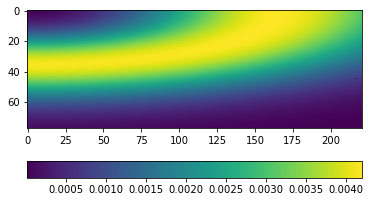

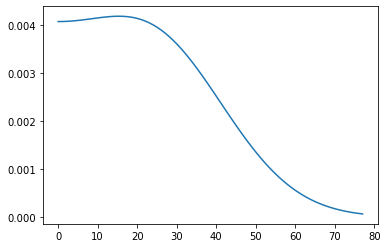

In [115]:
res = [get_ellipse_flux(x,y, lim=30) for x, y in zip(X, Y)] #.reshape(((n+1)/2, (N+1)/2))
flux = [r[0] for r in res]
er = [r[1] for r in res]
b2_half = np.array(flux).reshape((int((n+1)/2), int((N+1)/2)))
plt.imshow(b2_half)
plt.colorbar(orientation='horizontal')
plt.figure()
#plt.plot(b2_half[:, 150])

In [123]:
b2_flip0 = np.flip(b2_half[1:, :], axis=0)
b2_concat0 = np.concatenate((b2_flip0, b2_half))
b2_flip1 = np.flip(b2_concat0[:, 1:])
b2 = np.hstack((b2_flip1, b2_concat0))
b2 = b2/np.max(b2)
#np.save(array_path + 'b2_array.npy', b2)

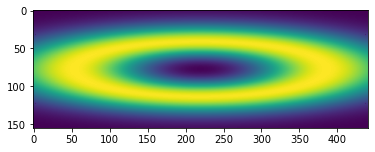

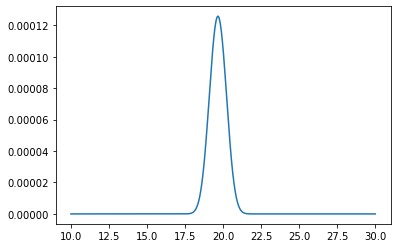

In [113]:
l = np.linspace(10, 30, 1000)
x = 1
y = AXn_half[77,0]*DA
plt.plot(l, integ(l, np.sqrt(x**2+y**2), np.arccos(x/(np.sqrt(x**2+y**2) + ep))))

In [100]:
AXn_half[-2]*DA

array([4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859786,
       4.33859786, 4.33859786, 4.33859786, 4.33859786, 4.33859